In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

file_path = '/content/drive/MyDrive/DICK Project/EMR/Patient_information_cleaned.csv'
df = pd.read_csv(file_path)


In [ ]:
file_path = '/content/drive/MyDrive/DICK Project/EMR/patient_procedure events.csv'
df1 = pd.read_csv(file_path)
df1.head()

,LOG_ID,MRN,EVENT_DISPLAY_NAME,EVENT_TIME,NOTE_TEXT
0,a739a81fc152e77c,3936fad285669edf,"Transported to PACU/ICU with O2, vital signs s...",8/9/19 11:47,NaN
1,a6494a6557e211ff,3b095ccb1c4f124f,Two Anti-Emetics Administered,6/17/19 11:54,NaN
2,a6494a6557e211ff,3b095ccb1c4f124f,Two Anti-Emetics Administered,6/17/19 11:54,NaN
3,e1a066d449ed18b0,499386c1a8693fd0,Sign In,4/27/19 0:38,NaN
4,e1a066d449ed18b0,499386c1a8693fd0,Quick Note,4/27/19 3:04,NaN


In [ ]:
top_10_values = df1['EVENT_DISPLAY_NAME'].value_counts().nlargest(10).index
df1 = df1[df1['EVENT_DISPLAY_NAME'].isin(top_10_values)]

In [ ]:
df1.shape

(449705, 5)

In [ ]:
df.shape

(64124, 23)

In [ ]:
import pandas as pd

top_10_values = df['DISCH_DISP_C'].value_counts().nlargest(10).index
df = df[df['DISCH_DISP_C'].isin(top_10_values)]

df.DISCH_DISP_C.value_counts()

,count
DISCH_DISP_C,
15.0,44207
20.0,8045
6.0,4623
100.0,1110
26.0,1082
3.0,981
4.0,812
30.0,776
16.0,599


In [ ]:
disp_map = df.dropna(subset=['DISCH_DISP', 'DISCH_DISP_C']).set_index('DISCH_DISP_C')['DISCH_DISP']

df['DISCH_DISP'] = df.apply(lambda row: disp_map.get(row['DISCH_DISP_C']) if pd.isna(row['DISCH_DISP']) else row['DISCH_DISP'], axis=1)

reverse_disp_map = df.dropna(subset=['DISCH_DISP', 'DISCH_DISP_C']).set_index('DISCH_DISP')['DISCH_DISP_C']
df['DISCH_DISP_C'] = df.apply(lambda row: reverse_disp_map.get(row['DISCH_DISP']) if pd.isna(row['DISCH_DISP_C']) else row['DISCH_DISP_C'], axis=1)
df.dropna(subset=['DISCH_DISP', 'DISCH_DISP_C'], how='all', inplace=True)



In [ ]:
disp_map = df.dropna(subset=['ASA_RATING', 'ASA_RATING_C']).set_index('ASA_RATING_C')['ASA_RATING']

df['ASA_RATING'] = df.apply(lambda row: disp_map.get(row['ASA_RATING_C']) if pd.isna(row['ASA_RATING']) else row['ASA_RATING'], axis=1)

reverse_disp_map = df.dropna(subset=['ASA_RATING', 'ASA_RATING_C']).set_index('ASA_RATING')['ASA_RATING_C']
df['ASA_RATING'] = df.apply(lambda row: reverse_disp_map.get(row['ASA_RATING']) if pd.isna(row['ASA_RATING_C']) else row['ASA_RATING_C'], axis=1)

df.dropna(subset=['ASA_RATING', 'ASA_RATING_C'], how='all', inplace=True)



array([ 15.,  16.,   6.,  20., 100.,   3.,  26.,  30.,   4.,  13.])

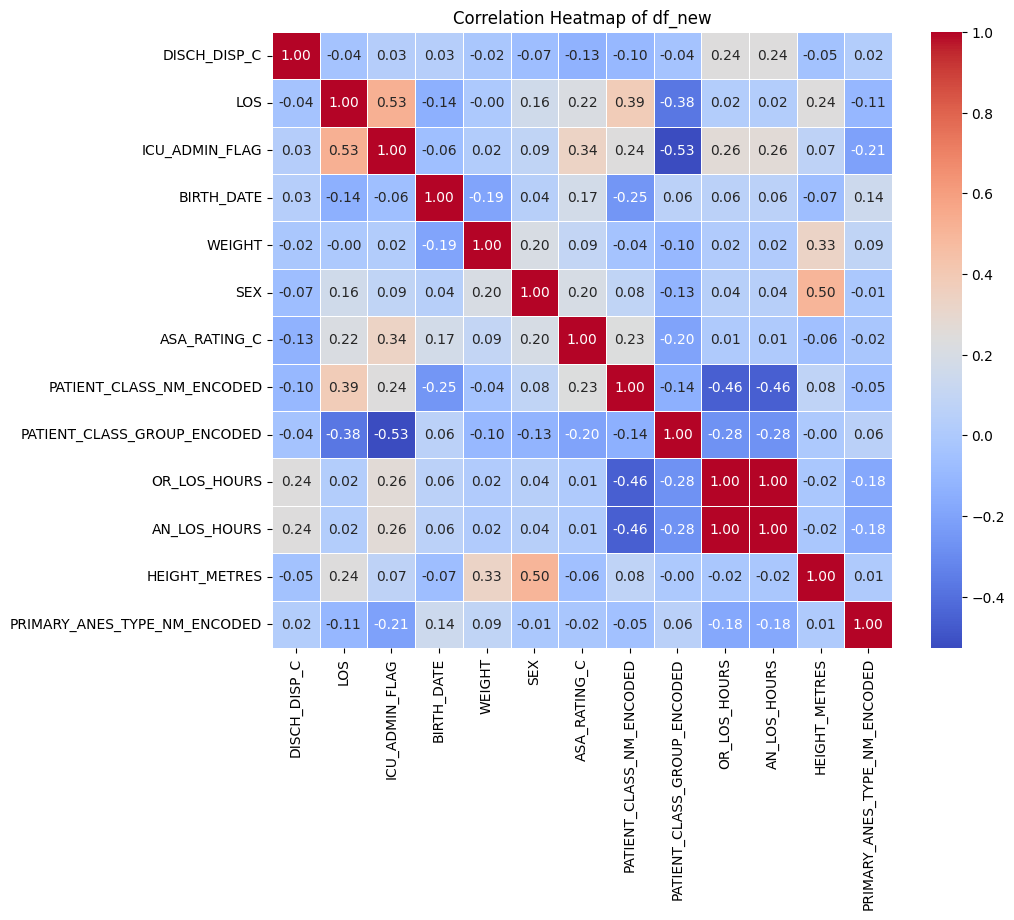

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df_new is already defined and cleaned

# Calculate the correlation matrix
correlation_matrix = df_new.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

# Display the heatmap
plt.title("Correlation Heatmap of df_new")
plt.show()


In [ ]:
df_new = df.drop(columns=["LOG_ID","MRN","DISCH_DISP","SURGERY_DATE","PRIMARY_ANES_TYPE_NM","ASA_RATING","PATIENT_CLASS_GROUP","PATIENT_CLASS_NM","PRIMARY_PROCEDURE_NM","PRIMARY_PROCEDURE_NM_ENCODED"])

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from sklearn.utils import resample


X = df_new[['DISCH_DISP_C', 'LOS', 'ICU_ADMIN_FLAG', 'WEIGHT', 'SEX',
        'PATIENT_CLASS_NM_ENCODED', 'PATIENT_CLASS_GROUP_ENCODED', 'HEIGHT_METRES']]
y = df_new['PRIMARY_ANES_TYPE_NM_ENCODED']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

y_encoded = to_categorical(y)



X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

model = Sequential([

    Dense(1024, input_shape=(X_train.shape[1],), activation='relu'),
    Dropout(0.3),
    Dense(512, activation='selu'),
    Dropout(0.5),
    Dense(256, activation='selu'),
    Dropout(0.3),
    Dense(128, activation='selu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='selu'),
    Dense(y_encoded.shape[1], activation='softmax')
])
learning_rate = 0.01
optimizer = RMSprop(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


history = model.fit(X_train, y_train, epochs=50, batch_size=32,
                    validation_split=0.2, verbose=1, callbacks=[early_stopping])


test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")





/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 28s 23ms/step - accuracy: 0.8512 - loss: 0.6489 - val_accuracy: 0.8684 - val_loss: 0.5306
Epoch 2/50
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 38s 20ms/step - accuracy: 0.8636 - loss: 0.5633 - val_accuracy: 0.8684 - val_loss: 0.5391
Epoch 3/50
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 26s 23ms/step - accuracy: 0.8627 - loss: 0.6607 - val_accuracy: 0.8684 - val_loss: 0.5397
Epoch 4/50
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 37s 20ms/step - accuracy: 0.8599 - loss: 0.6029 - val_accuracy: 0.8684 - val_loss: 0.5352
Epoch 5/50
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 26s 23ms/step - accuracy: 0.8616 - loss: 0.5556 - val_accuracy: 0.8684 - val_loss: 0.5734
Epoch 6/50
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 23s 20ms/step - accuracy: 0.8649 - loss: 0.6608 - val_accuracy: 0.8684 - val_loss: 0.5655
353/353 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8653 - loss: 0.5330
Test Accuracy: 86.01%


353/353 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00        54
           2       0.86      1.00      0.92      9708
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00        46
           6       0.00      0.00      0.00       943
           7       0.00      0.00      0.00       508
           8       0.00      0.00      0.00        18

    accuracy                           0.86     11287
   macro avg       0.10      0.11      0.10     11287
weighted avg       0.74      0.86      0.80     11287



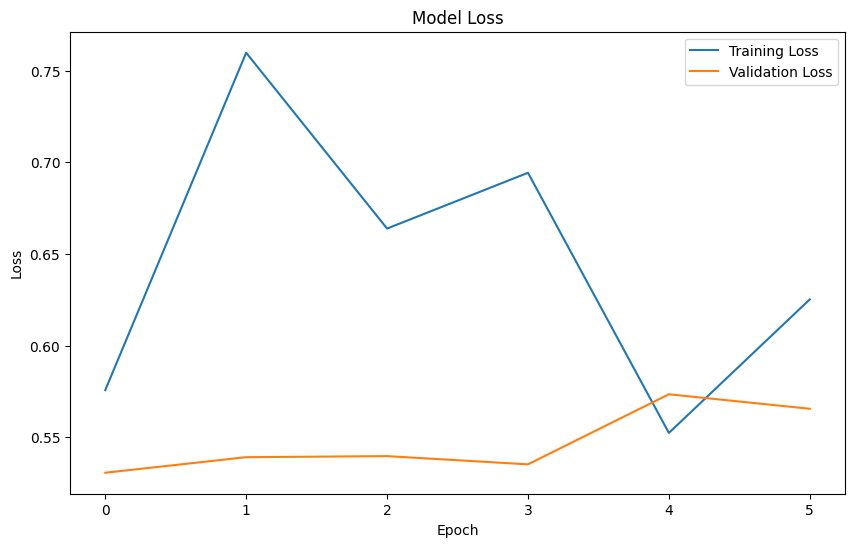

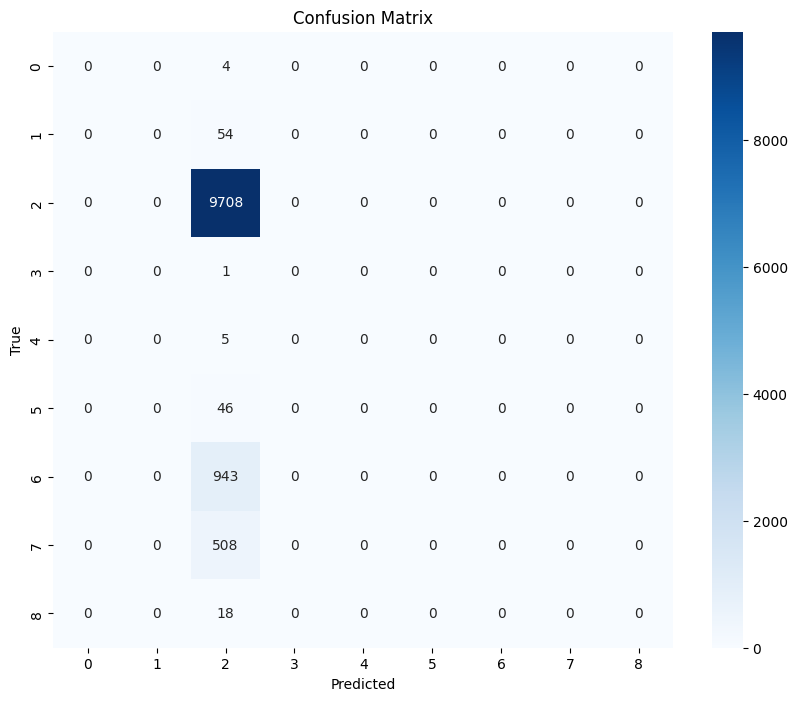

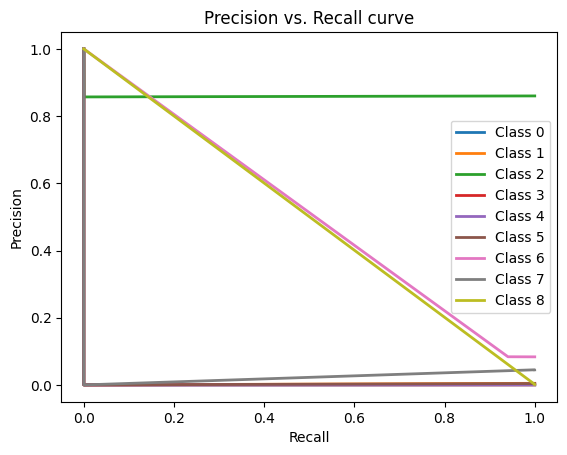

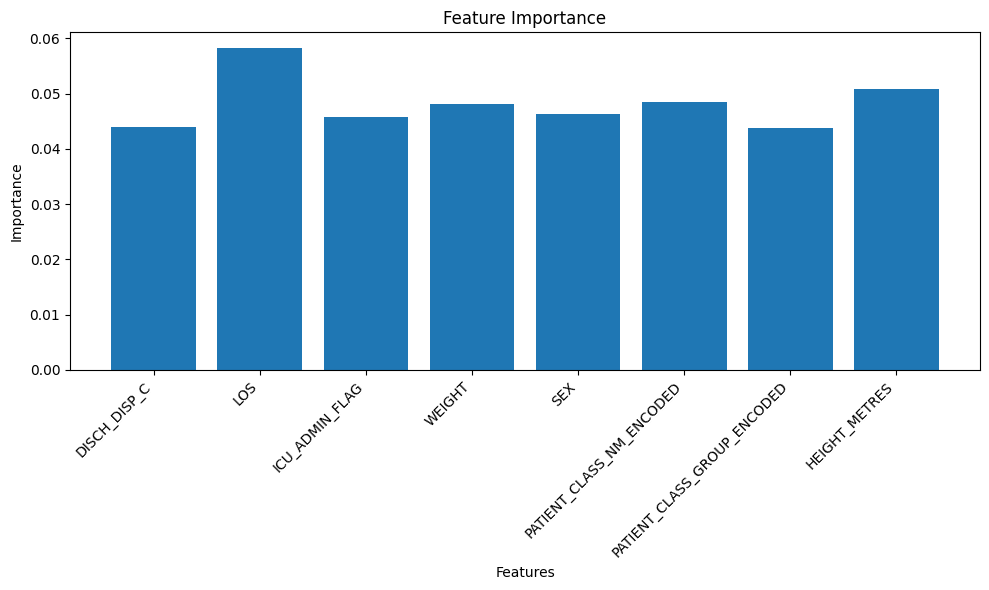

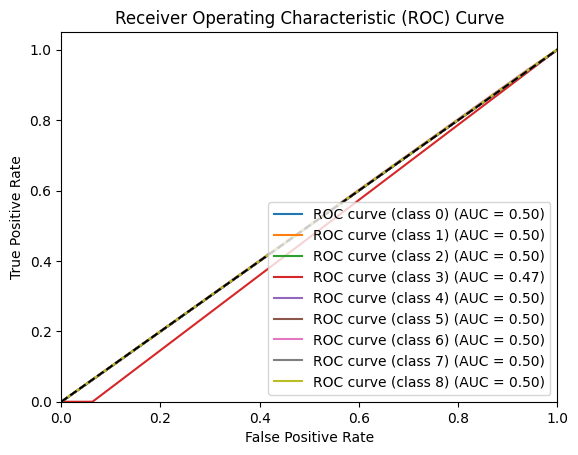

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve, auc
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.optimizers import RMSprop
import seaborn as sns

# Assuming you have already prepared your data and trained the model as shown in your code

# Classification Report
y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)
y_test_classes = y_test.argmax(axis=1)

report = classification_report(y_test_classes, y_pred_classes)
print("Classification Report:\n", report)

# Validation vs Test Loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Precision-Recall Curve
n_classes = y_encoded.shape[1]
precision = dict()
recall = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_pred[:, i])
    plt.plot(recall[i], precision[i], lw=2, label=f'Class {i}')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="best")
plt.title("Precision vs. Recall curve")
plt.show()

# Feature Importance
feature_importance = np.abs(model.layers[0].get_weights()[0]).mean(axis=1)
feature_names = X.columns
plt.figure(figsize=(10, 6))
plt.bar(feature_names, feature_importance)
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# ROC Curve
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
import joblib

# Assuming 'model' is your trained model
joblib.dump(model, 'trained_model_PRIMARY_ANES_TYPE_NM_ENCODED.pkl')


['trained_model_PRIMARY_ANES_TYPE_NM_ENCODED.pkl']